# Bitcoin Price Prediction - A CS 4675 Project
 Author: Shiyi Wang

## Dataset Preparation

The dataset I choose is [Bitcoin Historical Data](https://www.kaggle.com/mczielinski/bitcoin-historical-data) from [Kaggle](www.kaggle.com). The dataset contains one CSV file for select bitcoin exchanges for the time period of Jan 2012 to December March 2021, with minute to minute updates of OHLC (Open, High, Low, Close), Volume in BTC and indicated currency, and weighted bitcoin price.

Columns are as follows:
1. `Open` - Open price at start time window.
2. `High` - High price within time window.
3. `Low` - Low price within time window.
4. `Close` - Close price at end of time window.
5. `Volume_(BTC)` - Volume of BTC transacted in this window.
6. `Volume_(Currency)` - Volume of corresponding currency transacted in this window.
7. `Weighted_Price` - VWAP- Volume Weighted Average Price.


First, we import pandas to process dataframes.

In [190]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.dpi'] = 300

Now we can load our datasets. 

In [191]:
df = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Notice that the `Timestamp` column is in Unix format. Here I convert it into readable form and set it as the index column.

In [192]:
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')
df.index = df.Timestamp

Correspondingly, I resample the data based on 12 Hour frequency.

In [193]:
df = df.resample('12H').mean()
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 00:00:00,4.39,4.390000,4.39,4.390000,0.455581,2.000000,4.390000
2011-12-31 12:00:00,4.49,4.513333,4.49,4.513333,31.620766,141.106779,4.498804
2012-01-01 00:00:00,4.58,4.580000,4.58,4.580000,1.502000,6.879160,4.580000
2012-01-01 12:00:00,4.92,4.920000,4.92,4.920000,10.050000,49.450000,4.920000
2012-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Notice that some entries are NaN. Here, I fill in NaN with the previous value since it is a time series data.

In [194]:
df = df.fillna(method='ffill')

### OHLC & Volume Visualization

[mplfinance](https://github.com/matplotlib/mplfinance/blob/master/README.md) is a matplotlib utilities for the visualization, and visual analysis, of financial data.

In [195]:
import mplfinance as mpf

Here, I need to rename the BTC Volume column to satisfy the format of `mplfinance`.

In [196]:
df.rename(columns = {'Volume_(BTC)':'Volume'}, inplace = True)

Let's plot the OHLC with Volume.

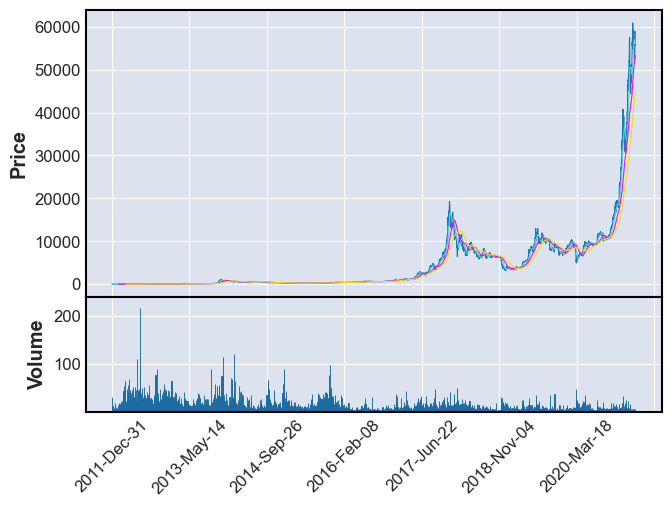

In [197]:
kwargs = dict(type='line', mav=(30, 90, 180), volume=True)
mpf.plot(df, **kwargs)

In this project, I choose to predict Bitcoin's `Weighted_Price` since it filters out the OHLC fluctuation and reduces ambiguity in representing Bitcoin price.

Therefore, here I drop other unnecessary columns for the sake of simplicity.

In [198]:
df = df.drop(columns=['Open', 'High','Low','Close','Volume','Volume_(Currency)'])
df.head()

,Weighted_Price
Timestamp,
2011-12-31 00:00:00,4.390000
2011-12-31 12:00:00,4.498804
2012-01-01 00:00:00,4.580000
2012-01-01 12:00:00,4.920000
2012-01-02 00:00:00,4.920000


Now, let's visualize the changes in `Weighted_Price` on a 12 Hour frequency.

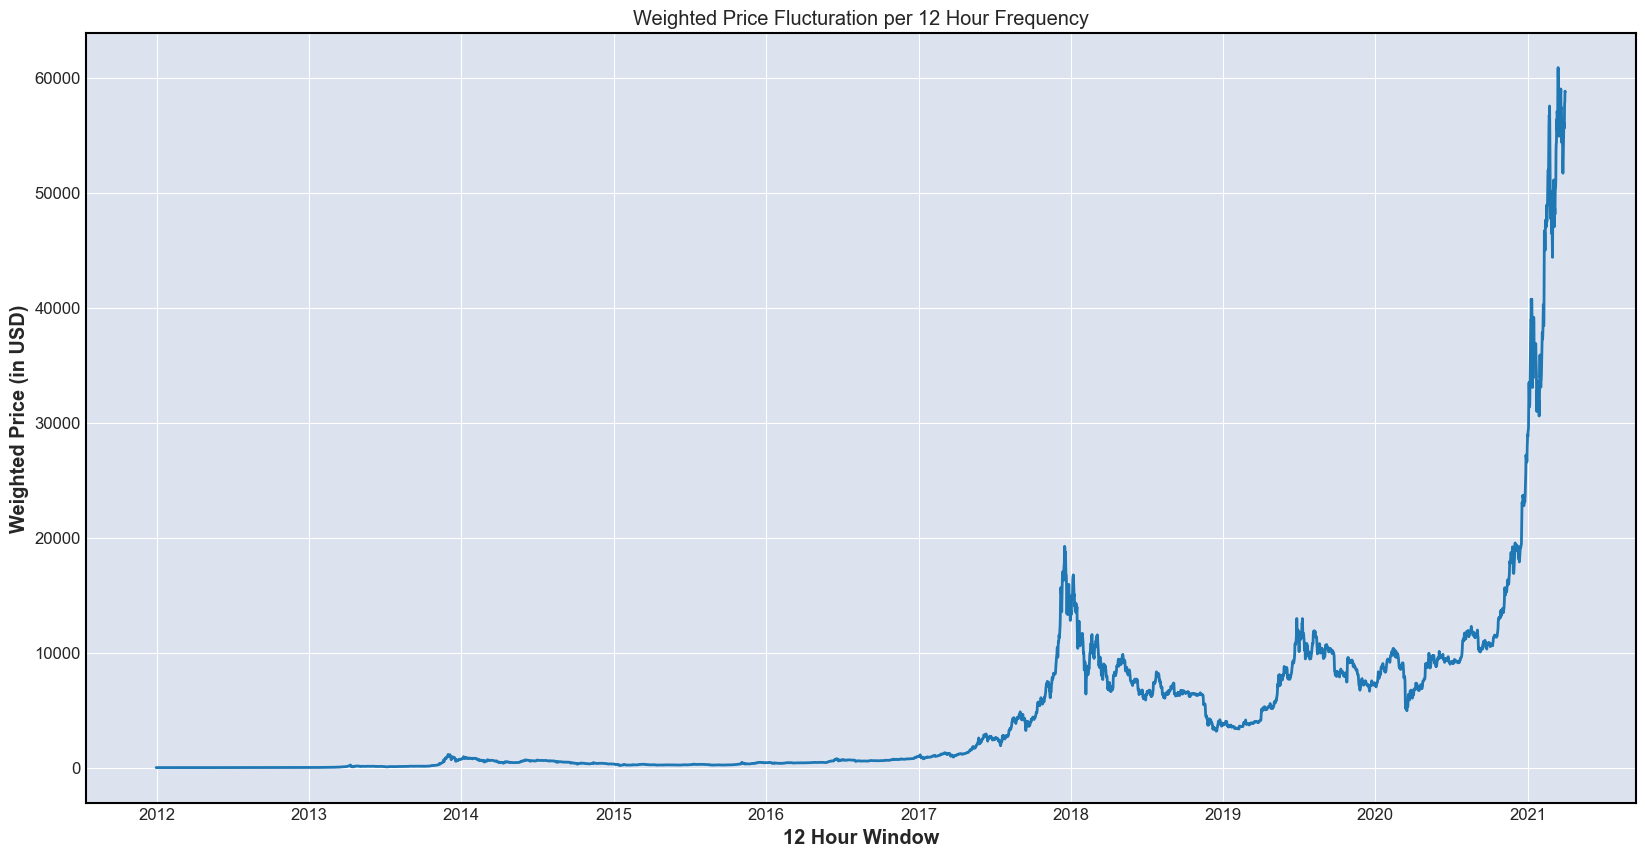

In [199]:
plt.figure(figsize=(20,10))
plt.plot(df["Weighted_Price"])
plt.title("Weighted Price Flucturation per 12 Hour Frequency")
plt.xlabel("12 Hour Window")
plt.ylabel("Weighted Price (in USD)")
plt.show()

## Prediction Model Implementation

### Hand Trained LSTM Model

#### Model Implementation

In [200]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

Let's make a copy of our dataframe for the LSTM model.

In [201]:
df_LSTM = df

I choose to split 80% of data for training and 20% for testing.

In [202]:
training_size = int(df_LSTM.shape[0] * 0.8) - 1
train = df_LSTM.iloc[:training_size, :]
test = df_LSTM.iloc[training_size:, :]

The exact training data size and testing data size are shown below.

In [203]:
print(train.shape)
print(test.shape)

(5404, 1)
(1353, 1)


We normalize dataset values by MinMax method.

In [204]:
scaler = MinMaxScaler(feature_range = (0, 1))
train_scaled = scaler.fit_transform(train.values)
test_scaled = scaler.fit_transform(test.values)

In LSTM, we need to group data. In this case, I group data in 50 * 12 Hr = 25 Days to predict the next group.

In [205]:
steps = 50

Process train data and test data.

In [206]:
x_train = []
y_train = []

for index in range(steps, train_scaled.shape[0] - steps):
    x_train.append(train_scaled[(index - steps):index, :])
    y_train.append(train_scaled[index, :])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape

(5304, 50, 1)

In [207]:
x_test = []
y_test = []

for index in range(steps, test_scaled.shape[0]):
    x_test.append(test_scaled[(index - steps):index, :])
    y_test.append(test_scaled[index, :])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape

(1303, 50, 1)

Hyperparameters tuning

Notes on `batch_size`: Due to the limited size of my training set, I choose 32. Small values give a learning process that converges quickly at the cost of noise in the training process.

In [208]:
epochs = 200 # Change this to 20 for faster running time
batch_size = 32

In [209]:
model = Sequential()
model.add(LSTM(units=50, return_sequences = True, input_shape = (x_train.shape[1],x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(loss="mse", optimizer="adam")
model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs)

Epoch 1/200
166/166 [==============================] - 15s 65ms/step - loss: 0.0025
Epoch 2/200
166/166 [==============================] - 10s 63ms/step - loss: 0.0012
Epoch 3/200
166/166 [==============================] - 10s 63ms/step - loss: 8.4780e-04
Epoch 4/200
166/166 [==============================] - 10s 61ms/step - loss: 8.7800e-04
Epoch 5/200
166/166 [==============================] - 13s 79ms/step - loss: 7.0742e-04
Epoch 6/200
166/166 [==============================] - 13s 81ms/step - loss: 7.0551e-04
Epoch 7/200
166/166 [==============================] - 14s 84ms/step - loss: 8.9782e-04
Epoch 8/200
166/166 [==============================] - 15s 88ms/step - loss: 6.0333e-04
Epoch 9/200
166/166 [==============================] - 12s 74ms/step - loss: 6.2792e-04
Epoch 10/200
166/166 [==============================] - 12s 74ms/step - loss: 5.6599e-04
Epoch 11/200
166/166 [==============================] - 12s 70ms/step - loss: 7.1513e-04
Epoch 12/200
166/166 [================

My LSTM Model consists of `5` hidden `50-neuron-layers` with `MSE` (Mean Square Error) loss function, `Adam` optimizer, and `200` Epochs.

In [210]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 50, 50)            10400     
                                                                 
 dropout_8 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_9 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 50, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 50, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)               

Now, let's compute `prediction` known as `y_hat`.

In [211]:
prediction = model.predict(x_test)
prediction = scaler.inverse_transform(prediction)
y_test = test[steps:].reset_index(drop=True)

Finally, let's visualize the predicted `Weighted_Price` using LSTM.

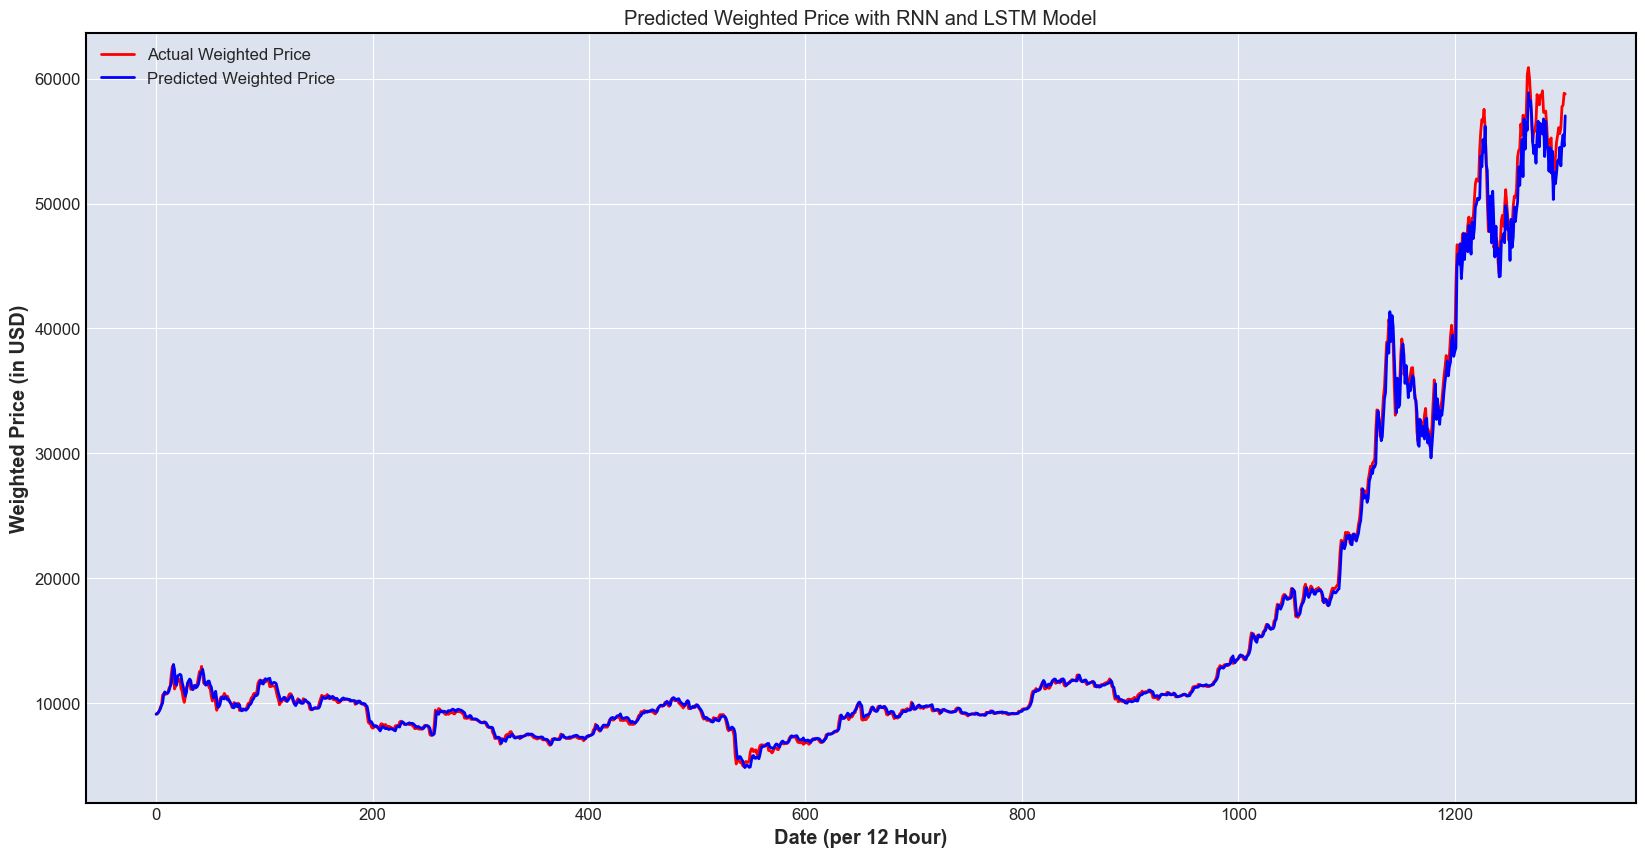

In [212]:
plt.figure(figsize = (20,10))
plt.plot(y_test['Weighted_Price'], color = 'red', label = 'Actual Weighted Price')
plt.plot(prediction[:,0], color = 'blue', label = 'Predicted Weighted Price')
plt.title('Predicted Weighted Price with RNN and LSTM Model')
plt.xlabel("Date (per 12 Hour)")
plt.ylabel('Weighted Price (in USD)')
plt.legend()
plt.show()

#### Future Prediction

Here I use `forecast` to store the next `50` steps prediction. Besides, I use `sliding_window` to store the the next timeframe.

In [213]:
forecast = []
sliding_window = []

First, we process the inputs.

In [214]:
inputs = test.reset_index(drop=True).values
inputs = scaler.transform(inputs)

Prepare Sliding Window by convert the array to numpy array for dimension mateches.

In [215]:
sliding_window.append(inputs[:steps, :])
sliding_window = np.array(sliding_window)
sliding_window = np.reshape(
    sliding_window, (sliding_window.shape[0], sliding_window.shape[1], 1))

Now, let's slide the "window".

In [216]:
for step in range(50):
    y_hat = model.predict(sliding_window)
    forecast.append(y_hat[0, :])
    y_hat = y_hat.reshape(1, 1, 1)
    sliding_window = np.concatenate(
        (sliding_window[:, 1:, :], y_hat), axis=1)

We now have our forecast.

In [217]:
forecast = scaler.inverse_transform(pd.DataFrame(forecast))

Finally, let's visualize the future prediction.

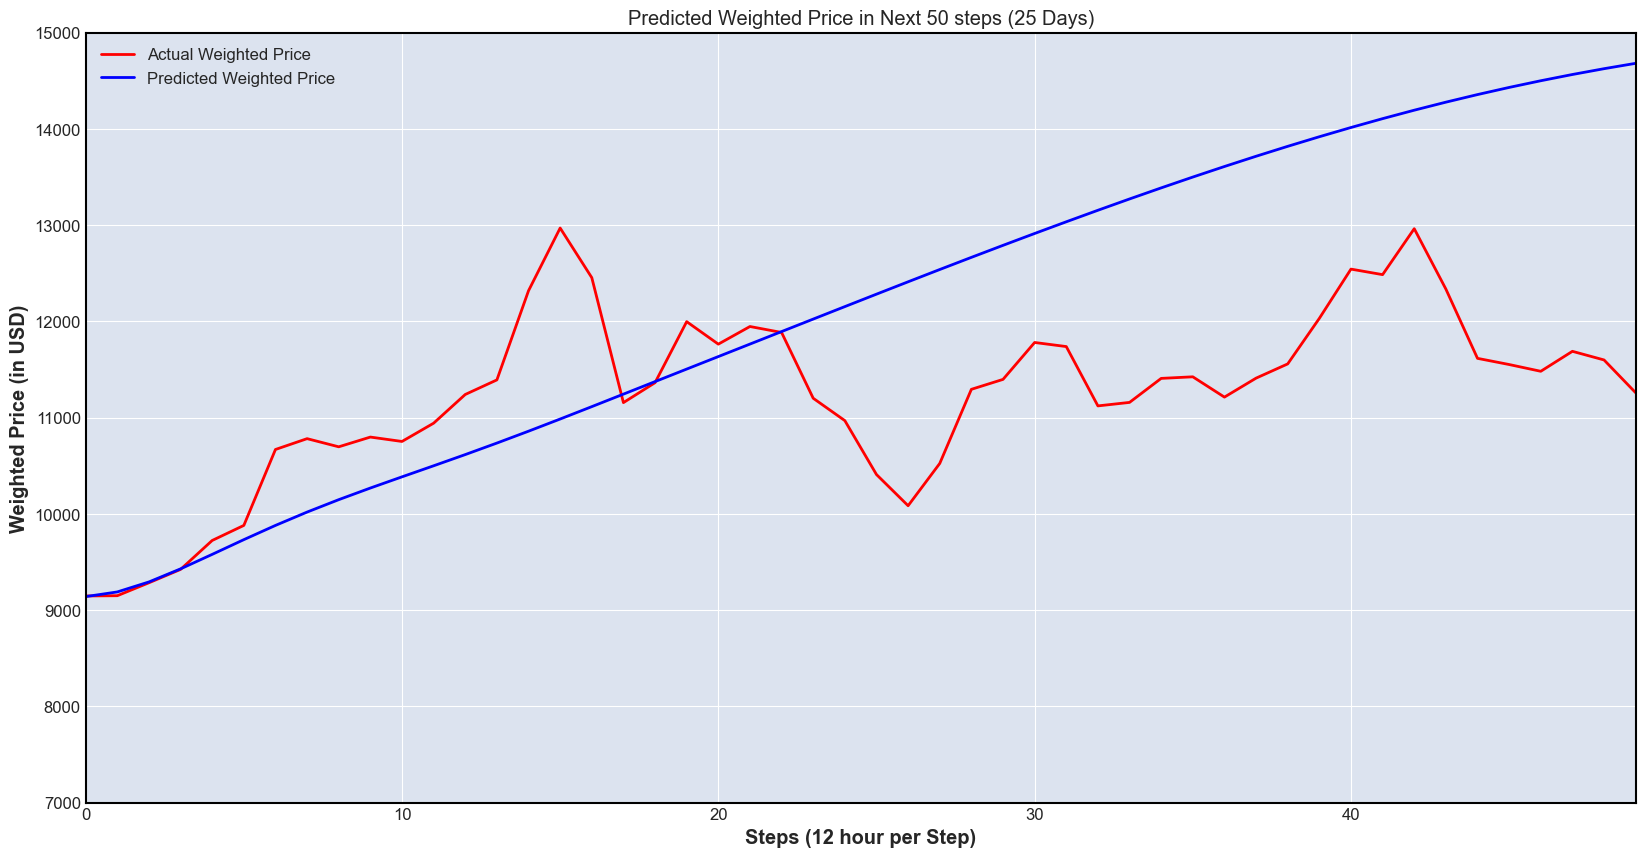

In [218]:
plt.figure(figsize=(20, 10))
plt.plot(y_test["Weighted_Price"], color='red', label='Actual Weighted Price')
plt.plot(forecast[:, 0], color='blue', label='Predicted Weighted Price')
plt.gca().set_xlim(0, forecast.shape[0]-1)
plt.gca().set_ylim(7000, 15000)
plt.title('Predicted Weighted Price in Next 50 steps (25 Days)')
plt.xlabel('Steps (12 hour per Step)')
plt.ylabel('Weighted Price (in USD)')
plt.legend()
plt.show()


Analysis: The Long Short-Term Memory (LSTM) is a variation of the RNN which solves the Vanishing Gradient Problem, which leads to the decrease in the gradient for each level in a regular RNN because of the Recurring Weight being close to 0. In my model, I use a time step of 50 meaning the input of time t gives a prediction of time t+50. The LSTM model predicts the Bitcoin price pretty accurately.

Analysis: In finance, there a phenomenon called Brownian Motion, which makes future values of stock prices independent of the past. In our case, it would be impossible to make long term predictions for Bitcoin price. In the future prediciton, the LSTM gives a correct increasing trend in Bitcoin price in the next 50 steps but failed to caputure the exact fluctuations. In this case, the fluctuation can be 2000+ USD dollars. 

### Facebook Prophet API

[Facebook Prophet](https://facebook.github.io/prophet/) is a forecasting procedure implemented in R and Python. It is fast and provides completely automated forecasts that can be tuned by hand by data scientists and analysts.

In [219]:
from fbprophet import Prophet

Format data for Prophet.

In [220]:
df_prophet = df.loc[:'2019-6-1']
ts = pd.DataFrame({'ds':df_prophet.index,'y':df_prophet.Weighted_Price})
ts['cap'] = 30000
ts['floor'] = 0

Fit and train the model to the data.

In [221]:
prophet = Prophet(weekly_seasonality=False,
                  changepoint_range=1, changepoint_prior_scale=1)
prophet.fit(ts)

future = prophet.make_future_dataframe(periods=50)
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


/Users/scott_wang/opt/anaconda3/envs/ml_4675_assignment3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -77.7524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       11962.2     0.0147571       762.346           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       12887.1     0.0148038       530.604           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       13521.9    0.00909369       2354.95      0.8395      0.8395      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       13791.1    0.00753922       672.765           1           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       14030.9    0.00171678       1242.05      0.4037      0.4037      572   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/scott_wang/opt/anaconda3/envs/ml_4675_assignment3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/scott_wang/opt/anaconda3/envs/ml_4675_assignment3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
0,2011-12-31 00:00:00,140.542034,-699.334549,988.267184
1,2011-12-31 12:00:00,138.489882,-728.142676,938.505376
2,2012-01-01 00:00:00,135.172902,-750.516080,969.955146
3,2012-01-01 12:00:00,133.127187,-751.329924,959.387410
4,2012-01-02 00:00:00,129.870302,-695.964321,1022.260383
...,...,...,...,...
5465,2019-07-17 12:00:00,9901.053035,8859.096116,10859.307872
5466,2019-07-18 12:00:00,9957.491484,8977.071555,11021.108229
5467,2019-07-19 12:00:00,10012.345082,8976.001618,11054.144262
5468,2019-07-20 12:00:00,10065.448328,9039.838517,11120.330888


Forecast and visualize the future.

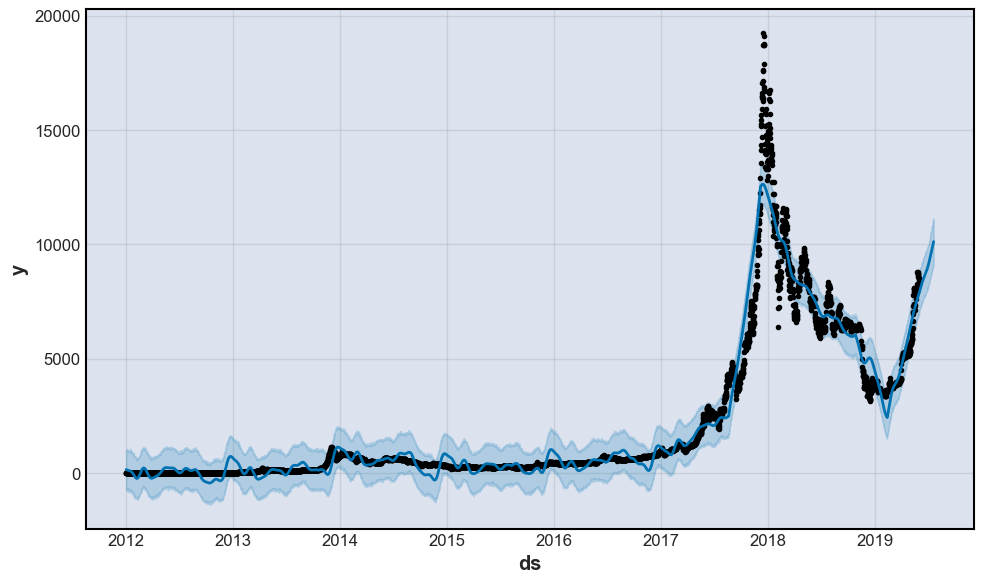

In [222]:
fig = prophet.plot(forecast)

Add lines to show detected changepoints.

In [223]:
from fbprophet.plot import add_changepoints_to_plot
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

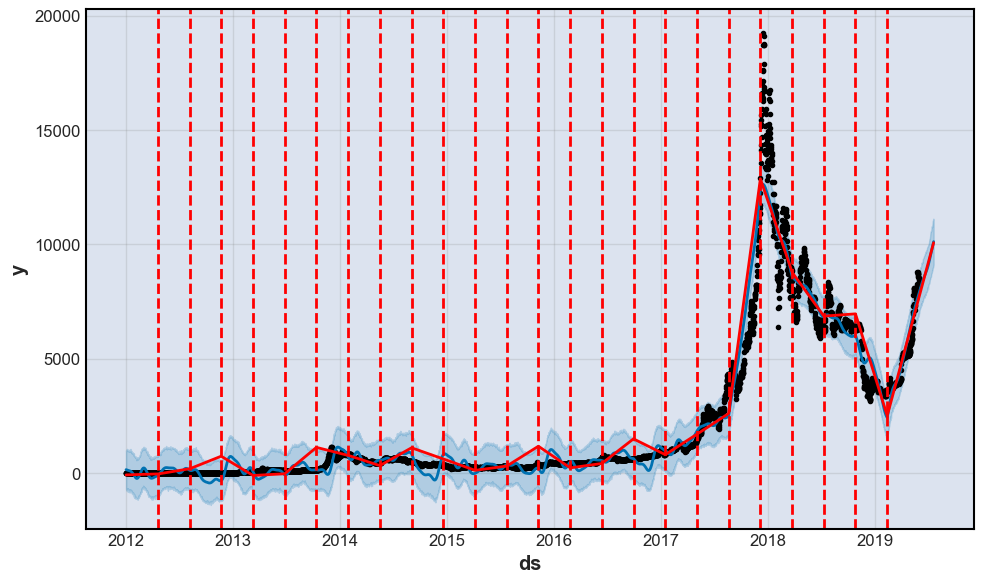

In [224]:
fig

Analysis: Facebook Prophet provide a clear forecast direction that the Bitcoin price will increase in the following years which can be validated with the real data. In the `changepoint` plot, it demonstrates the volatility of Bitcoin price.